In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from collections import Counter
import json
import time
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
from torchvision import transforms
import albumentations
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

# To have reproducible results and compare them
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)

In [13]:
train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

#ben's cropping

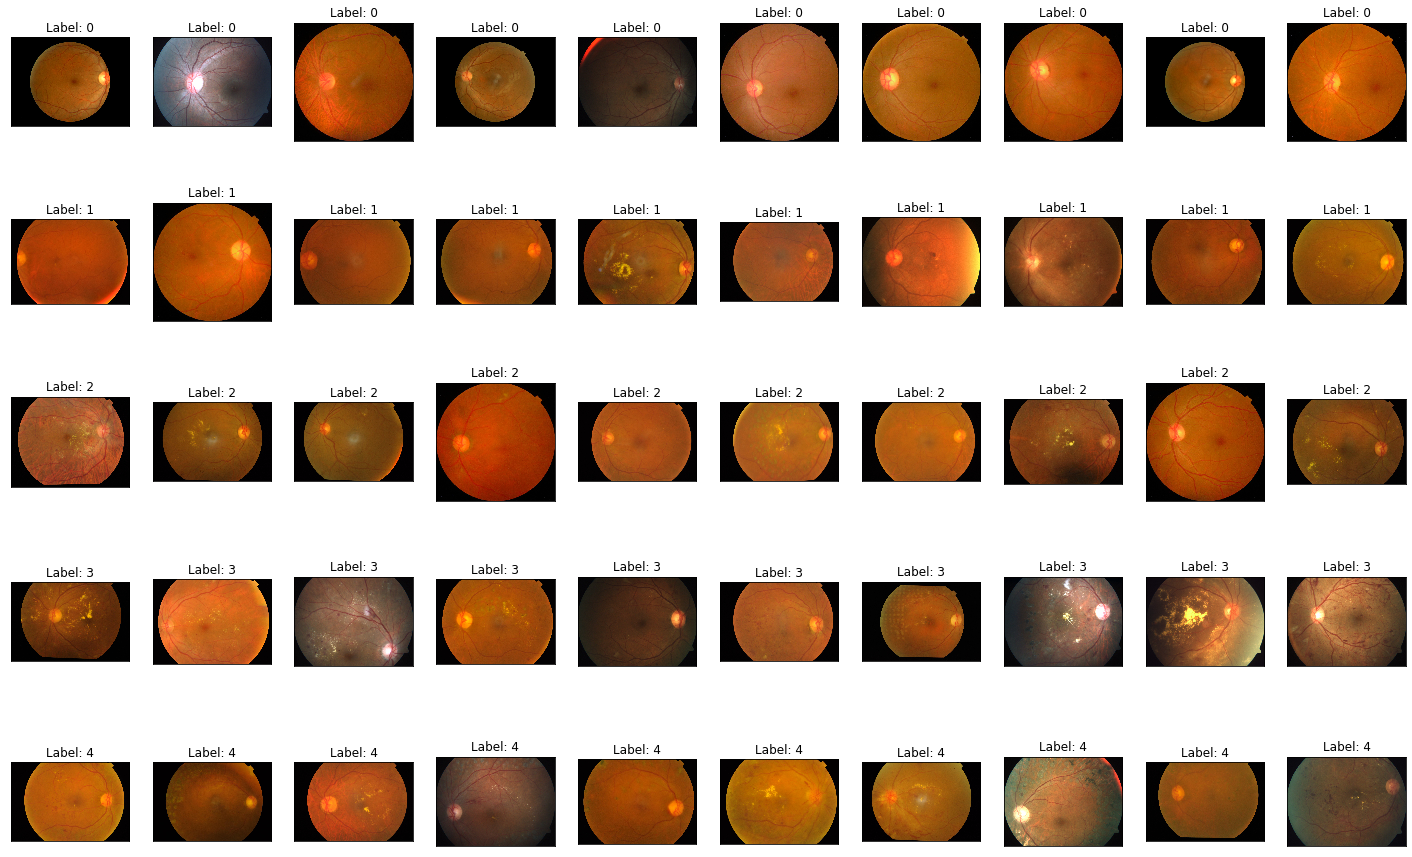

In [8]:
#Ref : https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(10).iterrows()):
        ax = fig.add_subplot(5, 10, class_id * 10 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png")
        plt.imshow(im)
        ax.set_title(f'Label: {class_id}')

In [35]:
"""
auto-cropping:
    輝度値の高いところを前景として、画像から切り出す手法のこと。
    グレースケール画像に使うコードをカラーに拡張した
"""
def crop_image1(img,tol=7):
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        
        return img


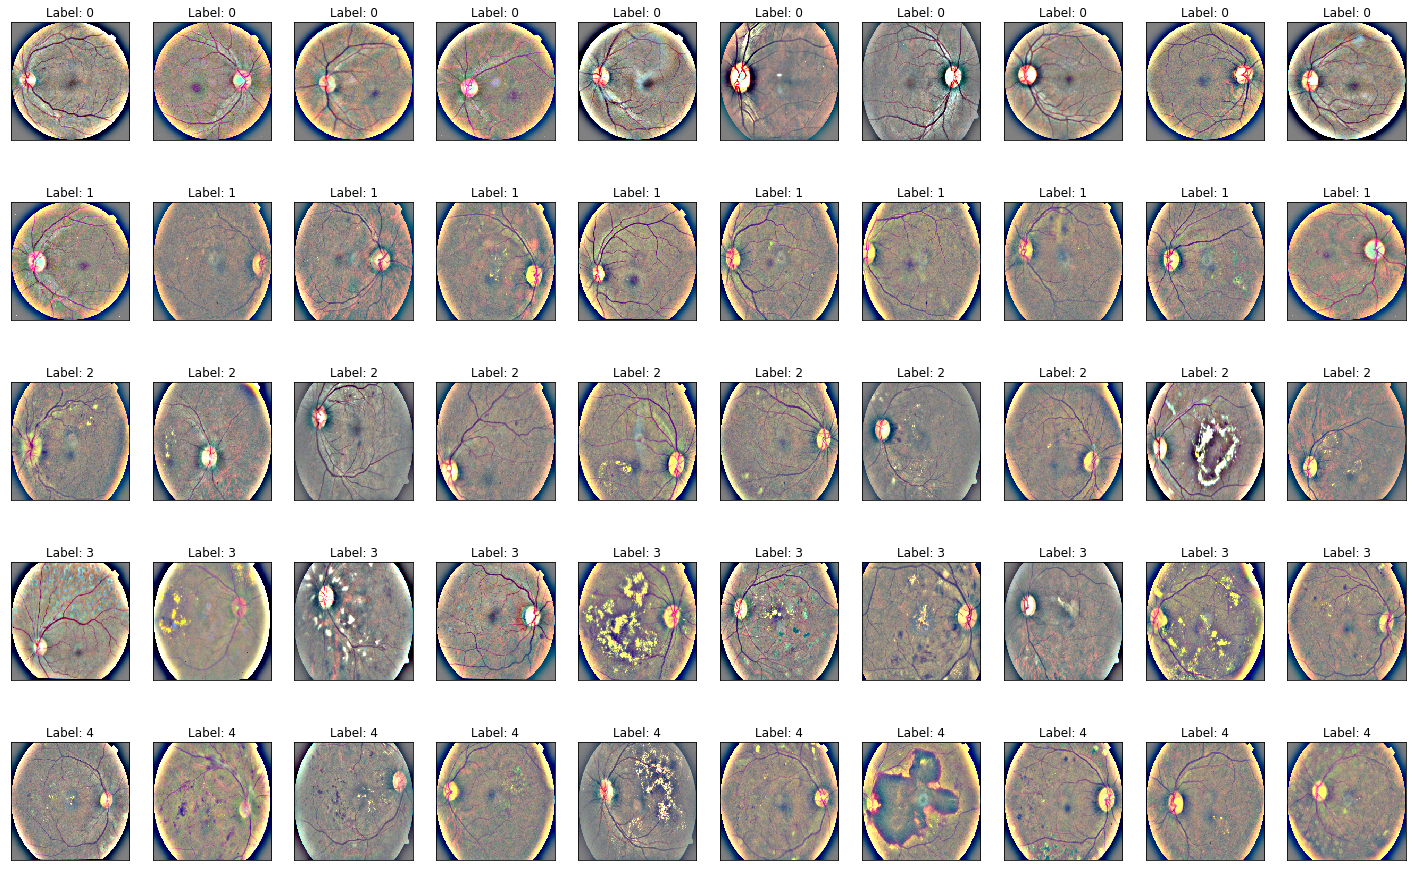

In [37]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(10).iterrows()):
        ax = fig.add_subplot(5, 10, class_id * 10 + i + 1, xticks=[], yticks=[])
        im = load_ben_color(f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png",
                            sigmaX=10)
        plt.imshow(im)
        ax.set_title(f'Label: {class_id}')

In [38]:
"""
circle_crop:
    円で切り分ける手法。
    処理としてはcrop_image_from_gray後のデータから
    楕円を検出し、円なるようaspectを調整後、
    再度crop_image_from_grayをかけている。
"""
def circle_crop(img, sigmaX=10):   
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

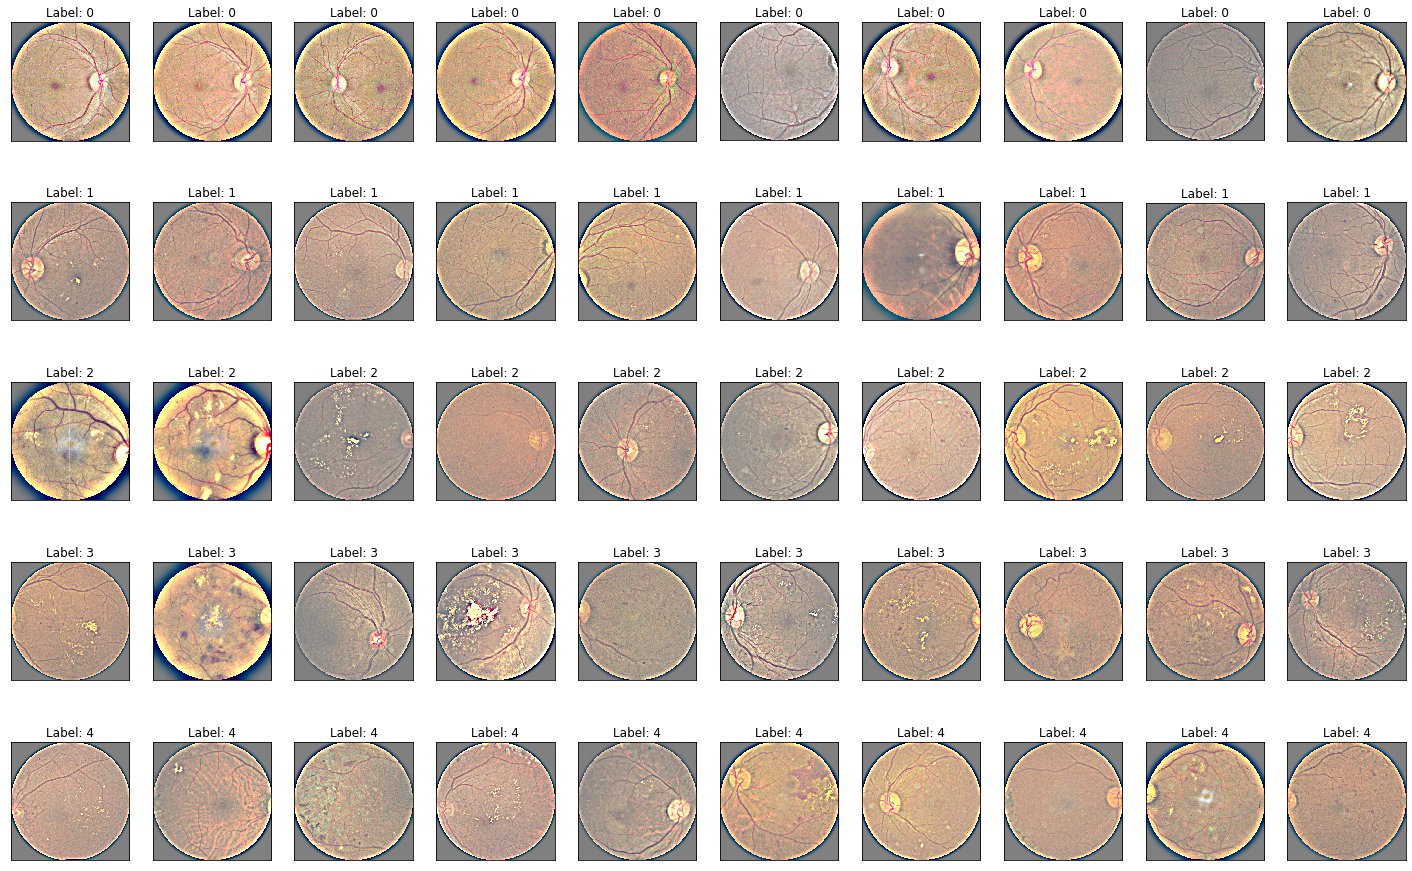

In [42]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(10).iterrows()):
        ax = fig.add_subplot(5, 10, class_id * 10 + i + 1, xticks=[], yticks=[])
        im = circle_crop(f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png",
                         sigmaX=30)
        plt.imshow(im)
        ax.set_title(f'Label: {class_id}')

#Augmentation using center-crop

In [55]:
class GlassDataset(Dataset):
    def __init__(self, df, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), y = None):
        self.df = df
        self.datatype = datatype
        self.image_files_list = [f'../input/aptos2019-blindness-detection/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
        if self.datatype == 'train':
            self.labels = y
        else:
            self.labels = np.zeros((df.shape[0], 5))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.circle_crop(img, sigmaX=10)
        image = self.transform(image=img)
        image = image['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels[idx]
        if self.datatype == 'test':
            return image, label, img_name
        else:
            return image, label
        
    def circle_crop(self, img, sigmaX=10):   
        height, width, depth = img.shape    

        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))

        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        img = crop_image_from_gray(img)
        img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
        return img 

In [58]:
data_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    #albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    #albumentations.torch.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(),
    #albumentations.torch.ToTensor()
    ])

dataset = GlassDataset(df=train, datatype='train', transform=data_transforms, y=train['diagnosis'])
test_set = GlassDataset(df=test, datatype='test', transform=data_transforms_test)

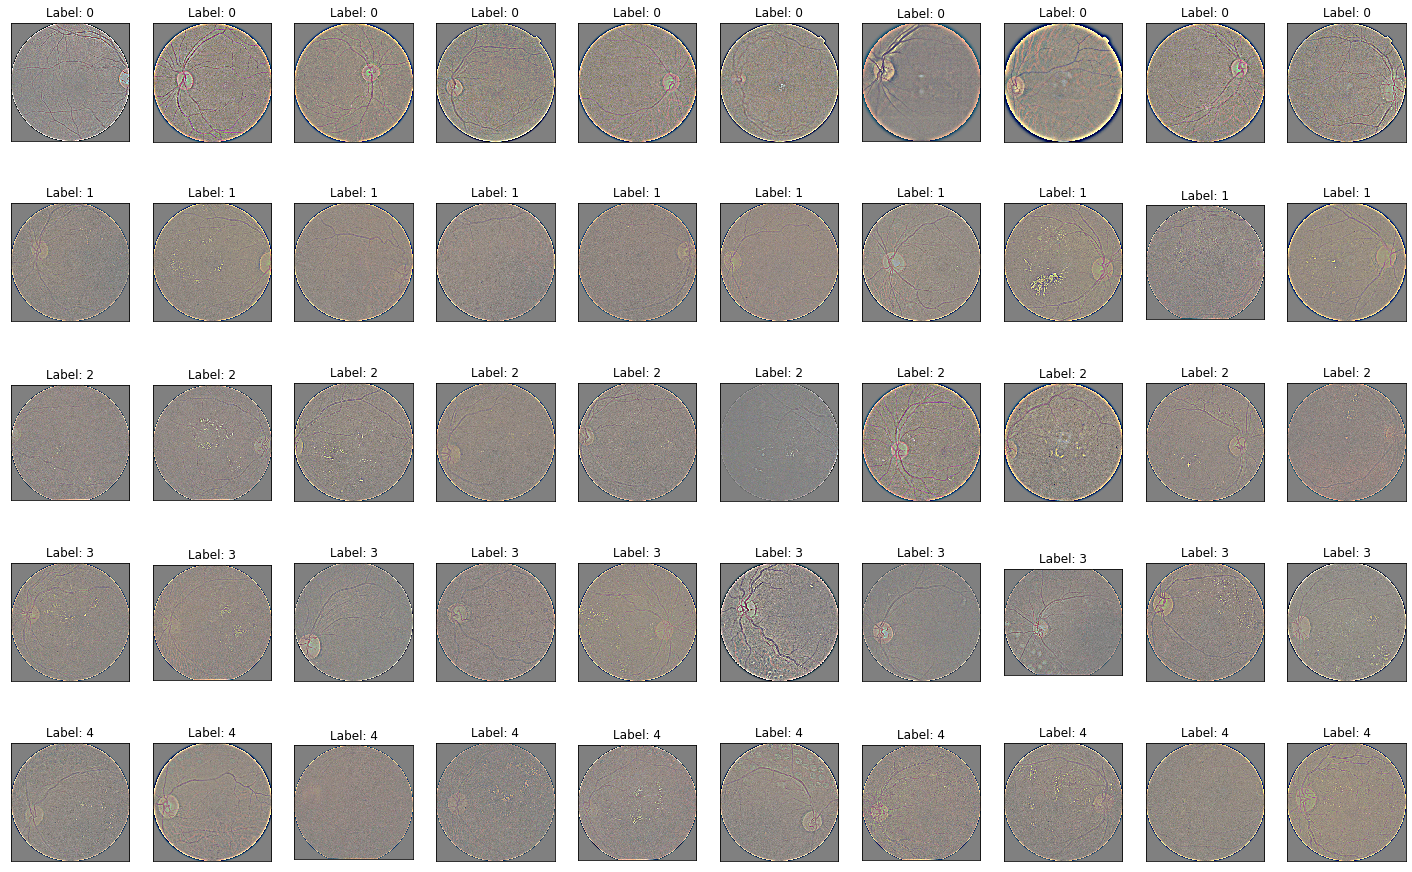

In [60]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(10).iterrows()):
        ax = fig.add_subplot(5, 10, class_id * 10 + i + 1, xticks=[], yticks=[])
        im,_ = dataset.__getitem__(idx)
        plt.imshow(im)
        ax.set_title(f'Label: {class_id}')